In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

import sys; sys.path.insert(0, '..') # add parent folder path where discrepancies folder is

from discrepancies import datasets, pool_reg, pool2graph_reg, evaluation, discrepancies_intervals, pool2graph_cat_FJ2_2

RANDOM_STATE = 42

import matplotlib.pyplot as plt
%matplotlib inline

### Reflexions sur comment étendre à la régression

##### FACON 1, la plus immédiate

- On peut discrétiser la variable continue en buckets. 
- Ex: '<5, 5-10, >10
- On va considérer que tous ceux dans <5 sont de la meme classe et explorer les changements avec les autres
- Gros effets de bord évidents

##### FACON 2

- On peut considérer des seuls personnalisés
- considérer que A et B sont à explorer Ssi leur y est au dessus d'un seuil
- Au début, on relie chaque obs à ses plus proches voisins qui ont un y assez différents. 
- On garde la valeur continue en mémoire
- Qu'est un intervalle ????

Xavier à 20, Thibault à 30. Seuil de 3, on explore. On se retrouve avec une suite de gens entre avec des y entre aussi. Le seuil est à 3, donc l'intervalle est les gens entre 23 et 27. Si ca repasse proche de X ou T, on considère qu'il y a plusieurs segments. 

- Nécessite probablement de recoder pas mal de conditions, puisque la classe est à considérer segment par segment et pas comme avant classes fixes.
- Idée: on regarde plus Classe A == Classe B, mais Classe A - CLasse B.


In [2]:
### Get data and fit a pool of classifiers on it

#X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='adult-cat')
X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='boston-reg', test_size=0.2)

print(X_train.shape, y_train.mean())
cont_names = list(set(feature_names) - set(cat_names))

(404, 13) 22.796534653465343


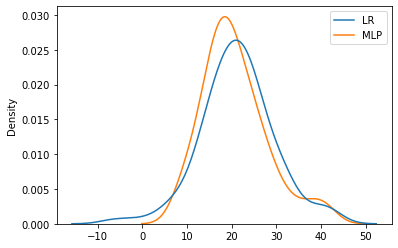

{'LR': 0.16866394539378704, 'MLP': 0.1879601358101555}


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5


4967


In [3]:

pool1 = pool_reg.BasicPool()
pool1 = pool1.fit(X_train, y_train)

sns.kdeplot(data=pool1.predict(X_test))
plt.show()


preds = pool1.predict(X_test)
from sklearn.metrics import mean_absolute_percentage_error#f1_score
print({c: mean_absolute_percentage_error(y_test, preds[c]) for c in preds.columns})


p2g = pool2graph_reg.pool2graph(X_train, y_train, pool1, 
                                discrepancy_regression_threshold=5.0, 
                                different_regression_threshold=5.0,
                                k_init=3)
#p2g = pool2graph.pool2graph(X_train, y_train, pool1, k_init=3)

p2g.fit(max_epochs=5)#5?
print(len(p2g.G.nodes))

In [13]:
from discrepancies import discrepancies_intervals
intervals = discrepancies_intervals.get_discrepancies_intervals(p2g.G)
print(len(intervals))

582


# Global analysis of the intervals

In [14]:
%load_ext autoreload

%autoreload 2
from discrepancies import analysis_global

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
### we work with that    
gda = analysis_global.GlobalDiscrepancyAnalyzer(p2g, pool1, intervals, X_train, cat_names)

Intervals amplitude dataset (self.amplitude_dataset): shape (582, 13)
Input data preprocessed (self.X): shape (404, 14)
Discrepancy nodes dataset (self.nodes_dataset): shape (2044, 13)
Nodes dataset (self.nodes_dataset): shape (4967, 14)


### Most problematic features

For now, we evaluate separately the uncertainty associated to each feature for continuous and categorical features.
- For continuous features: Average range of the discrepancy interval along the feature
- For categorical features: proportion of intervals generated along the feature, normalized by the exposition in Xtrain --> pas sûr qu'il faille normaliser par ça... car intercalle = 2 pts, X_train= chaque pt


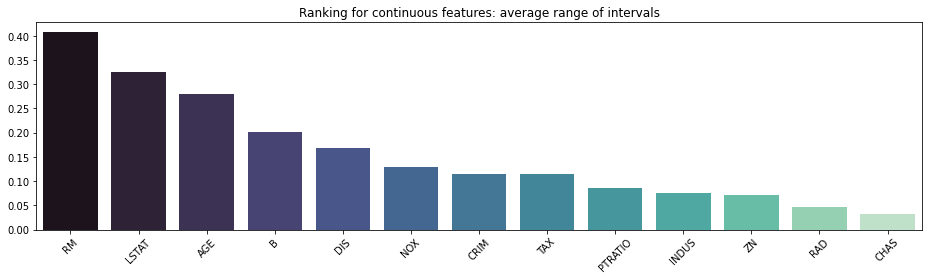

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt

feat_imp = gda.get_global_discrepancy_importances(min_expo=10)
#fname = '../../results/feature_importances_adult.pdf'
gda.plot_feature_importances(palettes=['mako', 'mako'])#, savefig='')

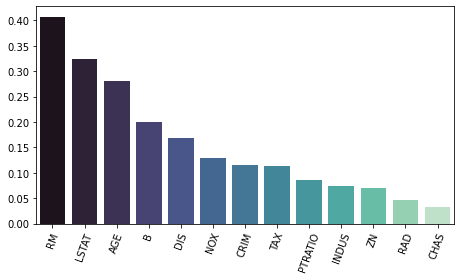

In [9]:
plt.figure(figsize=(len(feat_imp['continuous_features'])/2,4))
plt.xticks(rotation=70, fontsize=10)
sns.barplot(data=pd.DataFrame(feat_imp['continuous_features']).T, palette="mako")
#plt.title(" features")
plt.tight_layout()
#plt.savefig("./../../results/usecase_boston_featimp_cont.pdf")
plt.show()

## Important areas of discrepancy

In [17]:
%%time
gda.get_discrepancy_segments(X_exposition=X_train, y_exposition=y_train, min_expo=0.04, min_purity=0.5, min_purity_expo=0.0)

TypeError: __init__() got an unexpected keyword argument 'min_samples_expo'

In [11]:
%%time

LEAVES_SEGMENTS = (42, 51)

data = gda.disc_nodes_dataset.sample(n=30000)
leaves_data = gda.segments_tree.apply(data)
leaves_data_rearr = np.array([ld if ld in LEAVES_SEGMENTS else -1 for ld in leaves_data])

colors = list(sns.color_palette("Set2", n_colors=len(set(leaves_data))))

from sklearn.manifold import TSNE
tsne = TSNE(perplexity=40, n_jobs=-1).fit_transform(data)
tsne = pd.DataFrame(tsne, columns=["Dim 0", "Dim 1"])
tsne['leaf'] = leaves_data_rearr
#tsne["cluster"] = clusters
sns.scatterplot(x="Dim 0", y="Dim 1", data=tsne, hue="leaf", palette="Set2", alpha=0.7)#, c=[colors[i] for i in leaves_data_rearr.values])
plt.title("t-SNE vizualisation of discrepancy nodes")
#plt.legend()
plt.tight_layout()
#plt.savefig("./../../results/discussion_tsne_boston.pdf")

ValueError: Cannot take a larger sample than population when 'replace=False'

In [12]:
sns.scatterplot(x="Dim 0", y="Dim 1", data=tsne, hue="leaf", palette="Set2", alpha=0.1)#, c=[colors[i] for i in leaves_data_rearr.values])

NameError: name 'tsne' is not defined

In [ ]:
gda.disc_nodes_dataset.shape

# TODO
- Categorical: quand on génère les faux jumeaux, garder en mémoire les couples des modalités: blond-brun, et le changement associé?
- TSNE: couleurs 
- relative size: devrait être nombre de noeuds de discrepancy dans la feuille sur le nombre de noeuds de discrepancy